In [2]:
# Import Statements:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

# Creating Training and Testing Data:

csv_path = 'Coordinate_Classification_CNN/coords.csv'
folder_path = 'Coordinate_Classification_CNN/images'

coord_transform = transforms.ToTensor()

image_transform = transforms.Compose([transforms.ToTensor(),
                               transforms.CenterCrop(224)])

dataset = []

y = coord_transform(pd.read_csv(csv_path).values).squeeze().to(dtype=torch.float32)

y.shape

torch.Size([10000, 2])

In [3]:
images = sorted(os.listdir(folder_path))[1:]
images = sorted(images, key=lambda x: int(os.path.splitext(x)[0]))

for index, image_path in enumerate(images):

    image = image_transform(Image.open(f'{folder_path}/{image_path}'))

    coords = y[index]

    dataset.append([image, coords])

len(dataset)

10000

In [32]:
# Creating Constants:

LR = 3e-5
EPOCHS = 100

# Creating Training and Testing Split:

split = int(0.8 * len(dataset))

train_data, test_data = dataset[:split], dataset[split:]

# Batching Training and Testing Data:

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Creating Alex Net:

class AlexNet(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 96, 11, 4, 2)
        self.conv2 = nn.Conv2d(96, 256, 5, 1, 2)
        self.conv3 = nn.Conv2d(256, 384, 3, 1, 1)
        self.conv4 = nn.Conv2d(384, 384, 3, 1, 1)
        self.conv5 = nn.Conv2d(384, 256, 3, 1, 1)

        self.fc1 = nn.Linear(9216, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.out = nn.Linear(4096, 2)

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 3, 2)
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.max_pool2d(x, 3, 2)

        x = x.view(-1, 9216)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x) * 180
        
        return x

model = AlexNet()

# Creating Optimizer and Criterion:

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

criterion = nn.MSELoss()

# Creating Training Loop:

for epoch in range(EPOCHS):

    for batch, (x, y) in enumerate(train_loader):

        batch += 1

        y_pred = model(x)

        loss = criterion(y_pred, y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        if batch % 10 == 0:
            print(f'Epoch: {epoch} Batch: {batch} Loss: {loss:.4f}')
            

Epoch: 0 Batch: 10 Loss: 3735.8252
Epoch: 0 Batch: 20 Loss: 4177.2485
Epoch: 0 Batch: 30 Loss: 2523.7139
Epoch: 0 Batch: 40 Loss: 2439.8472
Epoch: 0 Batch: 50 Loss: 2893.9087
Epoch: 0 Batch: 60 Loss: 3110.1274
Epoch: 0 Batch: 70 Loss: 3789.2671
Epoch: 0 Batch: 80 Loss: 3014.3359
Epoch: 0 Batch: 90 Loss: 3712.8904
Epoch: 0 Batch: 100 Loss: 3150.4275
Epoch: 0 Batch: 110 Loss: 3153.4939
Epoch: 0 Batch: 120 Loss: 3307.2939
Epoch: 0 Batch: 130 Loss: 3808.6646
Epoch: 0 Batch: 140 Loss: 2574.1753
Epoch: 0 Batch: 150 Loss: 4329.9849
Epoch: 0 Batch: 160 Loss: 3312.6792
Epoch: 0 Batch: 170 Loss: 4064.0354
Epoch: 0 Batch: 180 Loss: 3847.6616
Epoch: 0 Batch: 190 Loss: 3488.0293
Epoch: 0 Batch: 200 Loss: 4413.7725
Epoch: 0 Batch: 210 Loss: 3076.2007
Epoch: 0 Batch: 220 Loss: 3094.0693
Epoch: 0 Batch: 230 Loss: 2956.8811
Epoch: 0 Batch: 240 Loss: 3311.2964
Epoch: 0 Batch: 250 Loss: 2736.8667
Epoch: 1 Batch: 10 Loss: 3333.0657
Epoch: 1 Batch: 20 Loss: 2420.8311
Epoch: 1 Batch: 30 Loss: 3636.3242
Epoc

In [44]:
torch.save(model.state_dict(), 'geolocation_model')

Actual: tensor([-32.4232, 148.9527])


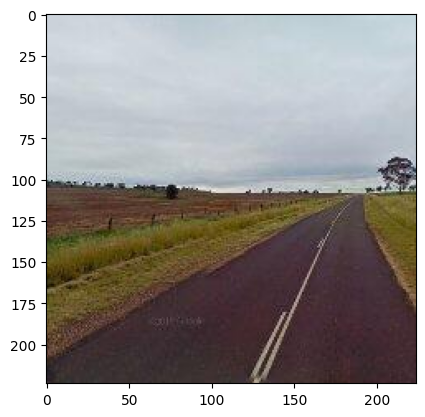

In [58]:
# Evaluating Accuracy of Model:

sample = train_data[123][0]

plt.imshow(sample.permute(1, 2, 0))
print(f'Actual: {train_data[123][1]}')
        

In [59]:
print(f'Prediction: {model(sample)}')

Prediction: tensor([[-31.8761, 146.2249]], grad_fn=<MulBackward0>)
